Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [3]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D


In [4]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

from google.colab import drive

drive.mount('/content/gdrive')
root_path = '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration'  #change dir to your project folder

Mounted at /content/gdrive


In [5]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*')))
print(image_count_test)

2239
118


### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Rescalling

In [11]:
# Keras.preprocessing
# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

BATCH_SIZE = 32 
# For VGG19 the input shape and size by deafult is 244,244 and hence the same is kept
IMG_HEIGHT = 600 # This should map with the height and width of the pretrained model
IMG_WIDTH = 450 # This should map with the height and width of the pretrained model
STEPS_PER_EPOCH = np.ceil(image_count_train/BATCH_SIZE)



In [12]:

train_data_gen = image_generator.flow_from_directory(
        directory='/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train',
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        color_mode="rgb",
        shuffle = False,
        classes = list(class_names),
        batch_size=BATCH_SIZE)

filenames = train_data_gen.filenames

Found 2239 images belonging to 9 classes.


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

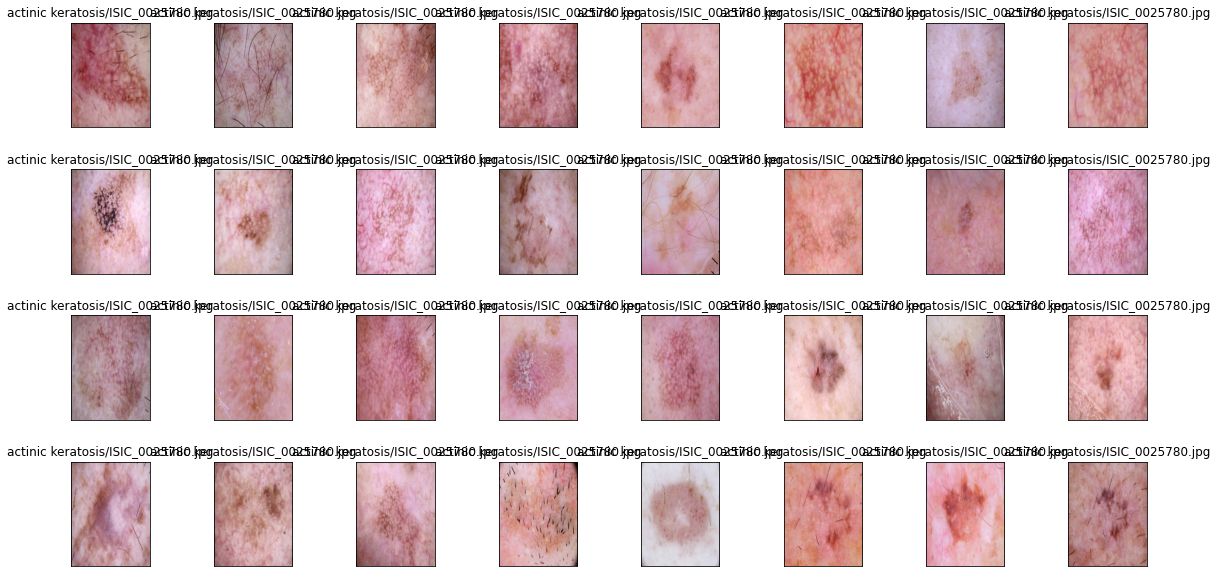

In [13]:
import matplotlib.pyplot as plt

images, labels = train_data_gen.next()

fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(wspace=0.2, hspace=0.4)

# Lets show the first 32 images of a batch
for i, img in enumerate(images[:32]):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(img)
    image_idx = np.argmax(labels[i])
    ax.set(title=filenames[image_idx])

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Model Building CNN

In [15]:
# model
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
                    layers.Conv2D(16,3, padding= 'same', activation='relu'),
                    layers.MaxPooling2D(),
                    layers.Conv2D(32,3 , padding= 'same', activation='relu'),
                    layers.MaxPooling2D(),
                    layers.Conv2D(64,3, padding= 'same', activation='relu'),
                    layers.MaxPooling2D(),
                    layers.Flatten(),
                    layers.Dense(128, activation= 'relu'),
                    layers.Dense(num_classes)
])



# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

### Setting Optimizer and Annealer

In [16]:
from keras.optimizers import Adam

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [17]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

### Train the model

In [18]:
epochs = 20
history = model.fit(
    train_ds, 
    validation_data= val_ds,
     epochs=epochs
     )

Epoch 1/20
56/56 [==============================] - 90s 1s/step - loss: 7.0746 - accuracy: 0.1112 - val_loss: 10.5128 - val_accuracy: 0.0895
Epoch 2/20
56/56 [==============================] - 50s 896ms/step - loss: 9.7064 - accuracy: 0.1073 - val_loss: 9.3033 - val_accuracy: 0.0895
Epoch 3/20
56/56 [==============================] - 50s 893ms/step - loss: 8.5171 - accuracy: 0.1063 - val_loss: 9.0868 - val_accuracy: 0.0895
Epoch 4/20
56/56 [==============================] - 50s 894ms/step - loss: 8.3535 - accuracy: 0.1231 - val_loss: 7.5727 - val_accuracy: 0.0962
Epoch 5/20
56/56 [==============================] - 50s 895ms/step - loss: 8.5474 - accuracy: 0.1182 - val_loss: 9.0146 - val_accuracy: 0.0895
Epoch 6/20
56/56 [==============================] - 50s 894ms/step - loss: 8.3889 - accuracy: 0.1051 - val_loss: 8.4737 - val_accuracy: 0.1096
Epoch 7/20
56/56 [==============================] - 50s 893ms/step - loss: 8.1191 - accuracy: 0.1206 - val_loss: 8.3295 - val_accuracy: 0.1141
E

### Visualizing the Results

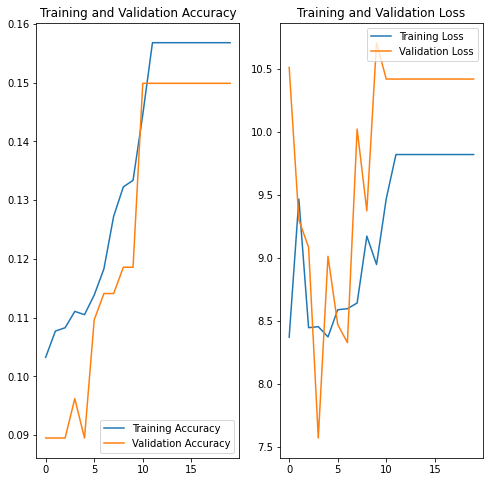

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analysis-

As you can see from the plots, training accuracy and validation accuracy are off by large margin and the model has achieved only around 15% accuracy on the validation set.

Let's look at what went wrong and try to increase the overall performance of the model.

### Class Imbalance

<BarContainer object of 9 artists>

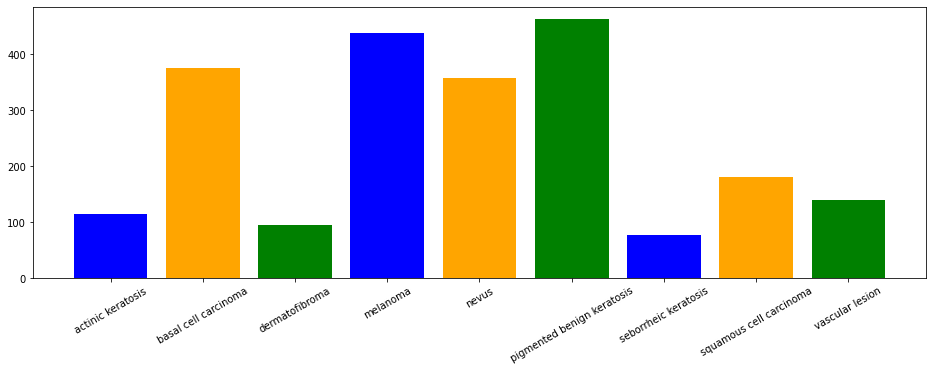

In [62]:
from collections import Counter
filenames_trimmed = [filename.split('/')[-2] for filename in filenames]
classes_count = Counter(filenames_trimmed)
# Plot the classes
plt.figure(figsize=(16,5))
plt.xticks(rotation=30)
plt.bar(classes_count.keys(), classes_count.values(), color=['blue', 'orange', 'green'], align= 'center')

My findings here:
##### Seborrheic Keratosis has the least number of samples

##### Pigmented Benign Keratosis and Melanoma dominate the data in terms proportionate number of samples

### We need to Rectify the class imbalance

### Data augmentation

In [25]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:



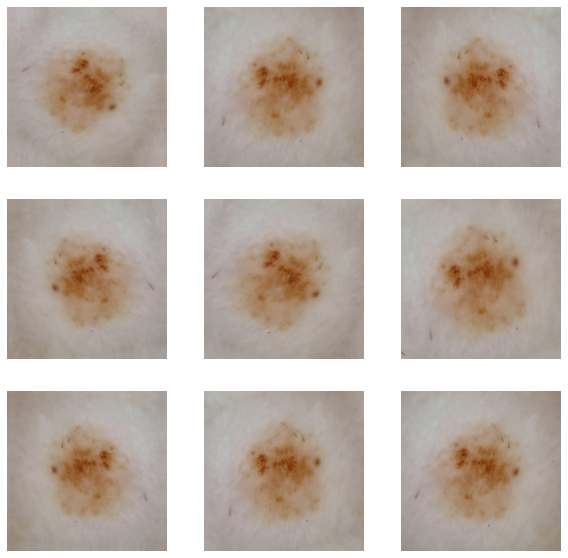

In [26]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Dropout
Another technique to reduce overfitting is to introduce Dropout to the network, a form of regularization.

When you apply Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network using layers.Dropout, then train it using augmented images.

In [27]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### Compile and train the model after Augmentation

In [34]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

#### Training the new model

In [67]:
epochs = 30

history = model.fit(
    train_ds, 
    validation_data= val_ds,
     epochs= epochs
     )

56/56 [==============================] - 59s 1s/step - loss: 4.8480 - accuracy: 0.2065 - val_loss: 4.7597 - val_accuracy: 0.2058


### Visualize training results

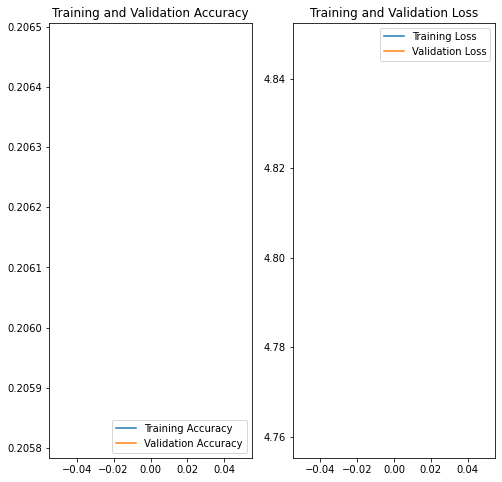

In [68]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()